# **ICS5110 Notebook**

View the web page for this project [here](https://mkenely.com/ics5110).

- [Feature Reference](https://mkenely.com/ics5110/features)
- [Feature Distributions](https://mkenely.com/ics5110/distributions)
- [Correlation Matrix](https://mkenely.com/ics5110/correlation_matrix)
- [Feature vs G3 Scatter Plots](https://mkenely.com/ics5110/scatter_plots)


### **Imports**

In [28]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pickle

from gradio_implementations import pca_gradio
from gradio_implementations import ensemble_gradio

import matplotlib.pyplot as plt

### **Data**

In [2]:
portugese_df = pd.read_csv('./data/Portuguese.csv')

le = LabelEncoder()
encoding_mappings = {}

for column in portugese_df.columns:
    if portugese_df[column].dtype == 'object':
        portugese_df[column] = le.fit_transform(portugese_df[column])
        encoding_mappings[column] = {index: label for index, label in enumerate(le.classes_)}

X = portugese_df.drop('G3', axis=1)
X = X.drop('G1', axis=1)
X = X.drop('G2', axis=1)

y = portugese_df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### **Models**

#### **PCA (Matthew)**

**Imports**

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

**Standardisation**
1. Subtract the mean from each variable
2. Divide by the standard deviation

In [4]:
X_s = X.copy()

for column in X.columns:
    X_s[column] = (X[column] - X[column].mean()) / X[column].std()

**Find number of components required to achieve two levels of explained variance: 95% and 90%**

In [5]:
accepted_v1 = 0.95
accepted_v2 = 0.90

pca = PCA()
pca.fit(X_s)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_1 = np.argmax(cumulative_variance >= accepted_v1) + 1
n_components_2 = np.argmax(cumulative_variance >= accepted_v2) + 1

In [6]:
print(f'{"Original features:":<1}{len(X.columns):>15}')
print(f'{"PCA components for variance 1: ":<1}{n_components_1:>2}')
print(f'{"PCA components for variance 2: ":<1}{n_components_2:>2}')

Original features:             30
PCA components for variance 1: 27
PCA components for variance 2: 24


**Fit normal model as well as two models with PCA at the two variance levels**

In [7]:
pca_1 = PCA(n_components=n_components_1)
pca_2 = PCA(n_components=n_components_2)

X_train_pca_1 = pca_1.fit_transform(X_train)
X_test_pca_1 = pca_1.transform(X_test)
X_train_pca_2 = pca_2.fit_transform(X_train)
X_test_pca_2 = pca_2.transform(X_test)

normal_model = LinearRegression()
pca_model_1 = LinearRegression()
pca_model_2 = LinearRegression()

normal_model.fit(X_train, y_train)
pca_model_1.fit(X_train_pca_1, y_train)
pca_model_2.fit(X_train_pca_2, y_train)

LinearRegression()

**Results**

In [8]:
normal_model_size = sys.getsizeof(pickle.dumps(normal_model))
pca_model_1_size = sys.getsizeof(pickle.dumps(pca_model_1))
pca_model_2_size = sys.getsizeof(pickle.dumps(pca_model_2))

normal_model_size_kb = normal_model_size / 1024
pca_model_1_size_kb = pca_model_1_size / 1024
pca_model_2_size_kb = pca_model_2_size / 1024

In [9]:
results_df = pd.DataFrame({
    'model': ['Normal', 'PCA 95%', 'PCA 90%'],
    'accuracy': [normal_model.score(X_test, y_test), pca_model_1.score(X_test_pca_1, y_test), pca_model_2.score(X_test_pca_2, y_test)],
    'model_size (KB)': [normal_model_size_kb, pca_model_1_size_kb, pca_model_2_size_kb],
    'relative_accuracy': [1, pca_model_1.score(X_test_pca_1, y_test) / normal_model.score(X_test, y_test), pca_model_2.score(X_test_pca_2, y_test) / normal_model.score(X_test, y_test)]
})

results_df['accuracy'] = results_df['accuracy'].apply(lambda x: round(x, 3))
results_df['model_size (KB)'] = results_df['model_size (KB)'].apply(lambda x: round(x, 3))
results_df['relative_accuracy'] = results_df['relative_accuracy'].apply(lambda x: round(x, 3))

results_df.set_index('model', inplace=True)

In [10]:
results_df.head()

,accuracy,model_size (KB),relative_accuracy
model,,,
Normal,0.304,1.253,1.000
PCA 95%,0.249,0.849,0.820
PCA 90%,0.238,0.802,0.784


In [11]:
# # Save to pickle for gradio
# models = [normal_model, pca_model_1, pca_model_2]
# pcas = [pca_1, pca_2]
# sizes = [normal_model_size_kb, pca_model_1_size_kb, pca_model_2_size_kb]

# with open('../gradio/pca_gradio/models/pca_models.pkl', 'wb') as f:
#     pickle.dump(models, f)

# with open('../gradio/pca_gradio/models/pcas.pkl', 'wb') as f:
#     pickle.dump(pcas, f)

# with open('../gradio/pca_gradio/models/sizes.pkl', 'wb') as f:
#     pickle.dump(sizes, f)


#### **Ensemble (David)**

**Imports**

In [12]:
import warnings

from sklearn.linear_model import LogisticRegression # to use Logistic Regression for step of stacking 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier # to use RF and GB as base models + the stacked model
from sklearn.metrics import accuracy_score # to get the accuracy

In [13]:
TARGET = "G3" # the target variable

# ONE_BOUND is the bounding area from the extremes (ie. 1 and -1), to remove the models that are too correlated with the target
# ZERO_BOUND is the bounding area from the middle (ie. 0), to remove the models that are too uncorrelated with the target
ONE_BOUND = 0.8
ZERO_BOUND = 0.065

TEST_SIZE = 0.2

**Models**

In [14]:
# the two base models for the stacking model
random_forest_model = RandomForestClassifier(n_estimators=100)
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100)

# stacking model that uses a 5 fold cross validation scheme (cv)
stacking_ensemble_model = StackingClassifier(estimators=[("random_forest", random_forest_model), ("gradient_boosting", gradient_boosting_model)], final_estimator=LogisticRegression(), cv=5)

In [15]:
correlation_matrix = portugese_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
correlation_matrix = correlation_matrix.mask(mask)

In [16]:
def filter_features(correlation_matrix, dataframe):
    original_features = dict(correlation_matrix.loc[TARGET])
    new_features = []
    removed_features = []

    # Iterate through features to determine which to keep or remove
    for key in original_features:
        if key == TARGET:
            new_features.append(key)  # Add target to the new dataframe
        elif original_features[key] > ONE_BOUND or original_features[key] < -ONE_BOUND:
            removed_features.append(key)  # High correlation
        elif -ZERO_BOUND < original_features[key] < ZERO_BOUND:
            removed_features.append(key)  # Low correlation
        else:
            new_features.append(key)  # Acceptable correlation range

    # Create the new dataframe
    new_data = {attribute: dataframe[attribute] for attribute in new_features}
    new_dataframe = pd.DataFrame(new_data)

    return new_dataframe, new_features, removed_features


In [ ]:
def run_the_model(dataframe, model_name, model_to_run):
    # Split dataframe into features and target
    features = dataframe.drop(columns=[TARGET])
    target = dataframe[TARGET]

    # Train-test split
    feature_train, feature_test, target_train, target_test = train_test_split(
        features, target, test_size=TEST_SIZE
    )

    # Train the model
    model_to_run.fit(feature_train, target_train)

    # Make predictions and calculate accuracy
    test_predictions = model_to_run.predict(feature_test)
    accuracy = accuracy_score(target_test, test_predictions)
    print(f"{model_name} Accuracy:\t{accuracy * 100:.3f}%")


In [22]:
print(f"Correlation values in range: {ONE_BOUND} to {ZERO_BOUND} and -{ZERO_BOUND} to -{ONE_BOUND}\n")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    temp = filter_features(correlation_matrix, portugese_df)
    new_dataset, kept_features, removed_features = temp[0], temp[1], temp[2]

    print(f"List of Kept Features:\t\t\t{kept_features}")
    print(f"List of Removed Features:\t\t\t{removed_features}")
    print(
        f"Original / Removed / Kept:\t\t"
        f"{len(portugese_df.keys())} / {len(removed_features)} / {len(kept_features)}"
    )

    run_the_model(new_dataset, "\nStacking Ensemble Model", stacking_ensemble_model)


Correlation values in range: 0.8 to 0.065 and -0.065 to -0.8

List of Kept Features:			['school', 'sex', 'age', 'address', 'Medu', 'Fedu', 'Mjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'higher', 'internet', 'romantic', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G3']
List of Removed Features:			['famsize', 'Pstatus', 'Fjob', 'famsup', 'paid', 'activities', 'nursery', 'famrel', 'G1', 'G2']
Original / Removed / Kept:		33 / 10 / 23

Stacking Ensemble Model Accuracy:	21.538%
[11 13 10 11 11 11 13 11 10 13 10 13 11 10 10 13 13 13 13 13 13 10 13 10
 11 11 10 11 12 13 11 13 10 10 11 11 11 13 11 10 11 11 11 13 11 14 14 10
 10 11 10 10 11 13 11 10 13 11 12 10 11 11 12 11 11 13 13 13 13 13 11 11
 10 11 10 12 13 11 11 11 10 10 13 13 13 11 11 13 11 11 11 13 13 13 13 13
 11 10 13 10 12 13 13 11 10 13 10 10 11 13 11 11 13 12 11 11 13 11 11 13
 11 11 11 11 13 12 13 11 11 10]


In [ ]:
# # Save to pickle for gradio
# with open('../gradio/ensemble_gradio/models/kept_features.pkl', 'wb') as f:
#     pickle.dump(kept_features, f)

# with open('../gradio/ensemble_gradio/models/stacking_ensemble_model.pkl', 'wb') as f:
#     pickle.dump(stacking_ensemble_model, f)

#### **K-Means Clustering (Karl)**

**Imports**

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

**Data**

In [25]:
#We must prepare the data first. K-means is not ideal for categorical data so we'll focus on the numerical.
X = portugese_df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'health', 'Dalc', 'Walc', 'G1', 
        'G2', 'G3', 'goout', 'freetime', 'absences']]
#Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

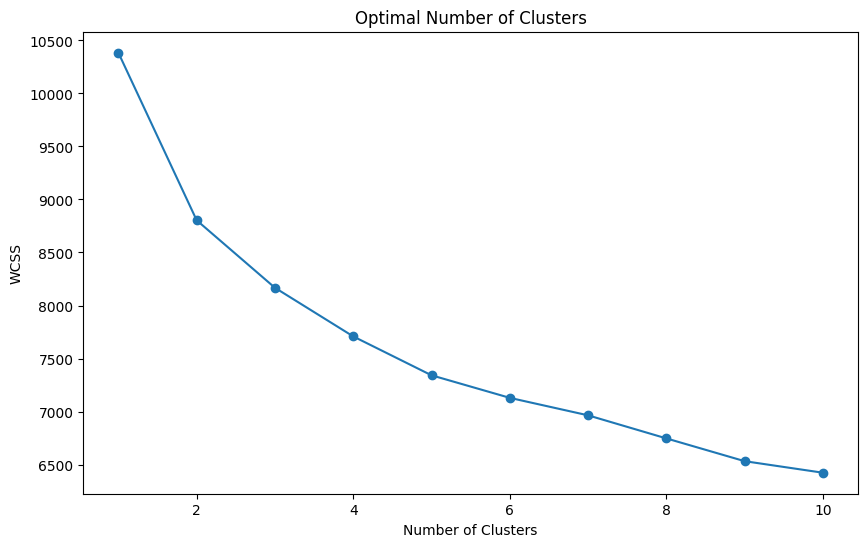

In [29]:
#Before we perform K-means, we must decide how many clusters we're going to use.
wcss = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
#Plotting elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
#From the elbow plot we can determine that the ideal no. of clusters is 2.
optimal_clusters = 2
cluster_df = portugese_df.copy()
#K-Means
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_df['Cluster'] = kmeans.labels_

In [41]:
#Displaying the dataset again with the cluster labels
print(cluster_df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'health', 'Dalc', 'Walc', 'G1', 
          'G2', 'G3', 'goout', 'freetime', 'absences', 'Cluster']].head())
print('\n')
#Analyzing the centroid values of each cluster
cluster_analysis = cluster_df.groupby('Cluster')[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 
                                          'health', 'Dalc', 'Walc', 'G1', 'G2', 'G3', 'goout', 'freetime', 
                                          'absences']].mean()
print(cluster_analysis)

   age  Medu  Fedu  traveltime  studytime  failures  famrel  health  Dalc  \
0   18     4     4           2          2         0       4       3     1   
1   17     1     1           1          2         0       5       3     1   
2   15     1     1           1          2         0       4       3     2   
3   15     4     2           1          3         0       3       5     1   
4   16     3     3           1          2         0       4       5     1   

   Walc  G1  G2  G3  goout  freetime  absences  Cluster  
0     1   0  11  11      4         3         4        1  
1     1   9  11  11      3         3         2        1  
2     3  12  13  12      2         3         6        0  
3     1  14  14  14      2         2         0        0  
4     2  11  13  13      2         3         0        0  


               age      Medu      Fedu  traveltime  studytime  failures  \
Cluster                                                                   
0        16.502717  2.877717  2.61413

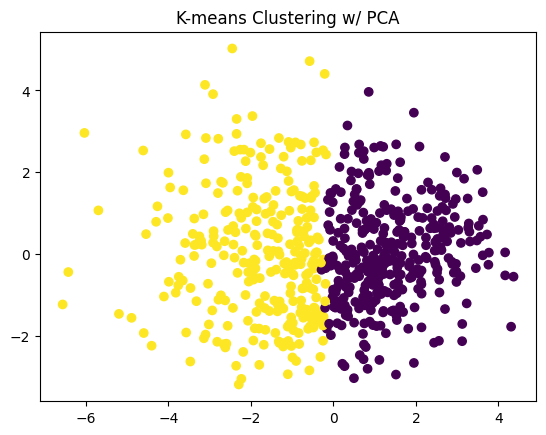

In [42]:
#Reducing the dimensionality to visualise it
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
#Plotting the PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_df['Cluster'], cmap='viridis')
plt.title('K-means Clustering w/ PCA')
plt.show()

### **Gradio**

#### **PCA**

In [20]:
pca_gradio.make_gradio(
    [normal_model, pca_model_1, pca_model_2],
    [pca_1, pca_2],
    [normal_model_size_kb, pca_model_1_size_kb, pca_model_2_size_kb],
)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


#### **Ensemble**

In [ ]:
# Drop G3 from kept features
kept_features.remove('G3')
ensemble_gradio.make_gradio(kept_features, stacking_ensemble_model)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
